# Genetic Algorithms Tutorial

This is a tutorial to implement a genetic algorithm using continuous numerical data. There are many ways to approach an implementation of a genetic algorithm, from different selection strategies, crossover and mutation operators, etc. but I am focusing on a simple example using the most standard of methods. Feel free to distribute, edit, make changes, improve, etc. this tutorial. If you publish this tutorial elsewhere, please let me know and link back.

## Genetic Algorithms

Genetic algorithms are a type of artificial intelligence algorithm which has many parallels to biological evolution. The goal of a genetic algorithm is to "evolve" some solution to a problem based on how fit that solution is. Over time, a collection of proposed solutions will converge to the real solution to the problem provided the genetic algorithm parameters are suitable.

Given an initial random population of solutions to the problem, the most fit solutions are (generally) kept and the remainder are discarded. Then, using genetic operators such as crossover and mutation, a new population is initialized which is comprised of mixtures of the best solutions.

There are a few things to consider when designing a genetic algorithm:

- what is the search space?
- what is the fitness function?
- what is the selection strategy?
- what are the crossover and mutation operators?
- what are the chances of crossover and mutation occurring?

The search space being the possible space in which the solution lies, the fitness function being a heuristic to gauge how fit a solution is, and the remainder I'll get to in the implementation.

Genetic algorithms are often referred to as metaheuristics, or a procedure which generates a solution to an optimization problem. In this tutorial, I'm effectively optimizing a given function and finding an optima. Metaheuristics can be used problem agnostically and can be applied to anything, really. One interesting way to use genetic algorithms is to train a neural network.

Just as a note on terminology: I say "solution", "candidate" and "chromosome" interchangeably. This is just one of the individuals from the population, the attributes of which are used to find the fitness of that individual. The most proper term would be "chromosome". A chromosome is comprised of "genes"; these are the attributes I had just mentioned.

### Pseudocode

A typical genetic algorithm may follow the below procedure:

```
procedure ga() is:
  initialize random population p of size n
  for each epoch do:
    sort p by fitness
    select elites e from p
    select tournament t from p
    sort t by fitness
    clear contents of p
    initialize empty mating pool m
    add e to m and p
    add t[0] to m
    for i in range 0..(n - m.size)/2 do:
      select two random parents p1, p2 from m
      initialize empty children c1, c2
      c1 := crossover(p1, p2)
      c2 := crossover(p1, p2)
      mutate(c1)
      mutate(c2)
      add c1, c2 to p
    endfor
  endfor
endprocedure
```

## Before you Begin

This tutorial uses Python with one dependency which needs to be met:

- Python 3.6
- GNU/Linux (or WSL, LXSS, etc.)
- X11 or alternative
- `matplotlib`

You can install `matplotlib` using `pip` although it's not entirely necessary to have `matplotlib` and it's only for illustrative purposes for this tutorial.

## Defining the Search Space and Fitness Function

This tutorial will use a common optimization test problem, the Styblinski-Tang Function, which is defined as:

$$f(x) = \frac{1}{2} \times \sum_{i=1}^d (x_i^4 - 16x_i^2 + 5x_i)$$

And can be visualized as below (credit to <a href="https://www.sfu.ca/~ssurjano/stybtang.html">the Virtual Library of Simulation Experiments</a>):

<img src="./images/stybtang.png"/>

This function can be applied to any dimensionality and has a global minima of $f(x^*) = -39.16599\times d$ at $x^* = (-2.903534, ..., -2.903534)$. For this tutorial, I'll be using a dimensionality of two to best visualize on a 2D plot. From the function, the global minimum in two dimensions is $-39.16599 \times 2 = -78.33198$. 

We have the fitness function, what about the search space? The interval in which our points will lay is $[-5, 5]$ as per the source above. We'll use this information to also generate a population later: we want to initialize a random population within the boundaries of the search space. Points in our system will be described as arrays of length `d`, where `d` is the dimensionality of the problem--in this case, two.

We'll define the search space and fitness function now:

In [1]:
SEARCH_MIN = -5.00 # minimum in search space
SEARCH_MAX = 5.00 # maximum in search space
DIMENSIONS = 2 # dimensionality of the problem

def styb_tang(point):
    """GA fitness function.
    Uses Styblinski-Tang Function in d dimensions.
    
    Parameters:
        point : a point in d-space.
    
    Returns:
        The fitness of that point.
    """
    summ = 0
    for d in point:
        summ += d**4 - (16 * d**2) + (5 * d)
    return (1 / 2) * summ

Just to verify the function is working as intended, we'll generate a "perfect point" with the known optimal position and evaluate its fitness:

In [2]:
OPTIMAL_POINT = [-2.903534, -2.903534]
print(styb_tang(OPTIMAL_POINT))

-78.3323314075428


This is not exact but $-78.33233 \approx -78.33198$ so it's close enough for our purposes. We know our global minima is around this point. We've initialized this as a global variable because we want to see where the minima is in our plots.

## Population Initialization

For our genetic algorithm to work, we need to first initialize a random population of candidate solutions to the problem. Since we're optimizing a mathematical function in two dimensions, a candidate solution is simply any x,y-coordinate pair. For example, our optimal pair was `(-2.903534, -2.903534)`. The key point, however, is the candidate solutions are random initially. 

We can generate a population like the below, using a population size of `200` since this is a relatively trivial problem:

In [3]:
import random

POP_SIZE = 200 # the population size

def initialize_population(size, dim, min, max):
    """Initializes a random population.
    
    Parameters:
        size : the size of the population.
        dim : the dimensionality of the problem
        min : the minimum in a dimension for the search space.
        max : a maximum in a dimension for the search space.
    
    Returns:
        A random population of that many points within the bounds of the space.
    """
    population = [] # population stored as a list
    for _ in range(size): # for the size of the population
        point = [] # point as well as a list
        for _ in range(dim): # to fill each axes
            # generate a random position for that axes
            point.append(random.uniform(min, max))
        population.append(point) # add to population
    return population

POPULATION = initialize_population(POP_SIZE, DIMENSIONS, SEARCH_MIN, SEARCH_MAX)

Just to verify, we'll print out a few candidate solutions to ensure they were initialized properly within the correct range:

In [4]:
random.shuffle(POPULATION)
for i in range(5):
    print(POPULATION[i])

[-0.6530169548693934, -4.6814721616989665]
[4.168075810739895, 1.4204781130183894]
[-3.5998866466841495, 4.572632651584284]
[-2.17017903999336, 4.010059217894188]
[-3.5996759481353258, 0.15592625086268708]


Now that we know points are generated within the right range, we can make a plotter to see their positions relative to the known global optima. For this tutorial, we're limiting it to two dimensions, as while the algorithm is dimensionality agnostic so far, we cannot easily visualize points in higher dimensional space.

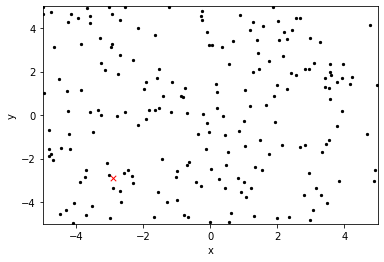

<Figure size 432x288 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt

def plot_points(pop, opt):
    x = [pop[i][0] for i in range(len(pop))]
    y = [pop[i][1] for i in range(len(pop))]
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(SEARCH_MIN, SEARCH_MAX)
    plt.ylim(SEARCH_MIN, SEARCH_MAX)
    plt.scatter(x, y, c='k', s=5, lw=1)
    plt.scatter(opt[0], opt[1], c='r', marker='x', s=30, lw=1)
    plt.show()
    plt.clf()

plot_points(POPULATION, OPTIMAL_POINT)

Here we can see where each point lies within the search space as denoted by a black dot. The global optimum is denoted by a red 'x'. We'll use this plotting function a few more times to visualize how further iterations of the population will creep closer to the global optima.

## Mating Pool Selection

The way genetic algorithms work is they take the most fit individuals of a population and generate offspring from them. There's a careful balance needed here to maintain diversity in the population (so the algorithm does not stagnate to local minima) but also propagate the best fit individuals into next generations (so the algorithm does improve over time). To this end, elites are chosen as well as a tournament is conducted to determine which candidates in the population become parents for the next generation.

The general idea of population evolving can be visualized below:

<img src="./images/population_evolution.png" width="70%"/>

Here, a population of twelve candidates is already sorted from most fit to worst fit (blue means more fit). Elites (yellow) are chosen which go into the new generation verbatim but also join the mating pool (purple). A tournament (green) is also conducted between a random subset of the population. The elites and the winner of the tournament go into the mating pool which go on to populate the remainder of the population (burgundy).

First, the population is sorted by overall fitness and we output some of the most fit:

In [6]:
def print_five_best():
    global POPULATION
    POPULATION = sorted(POPULATION, key=styb_tang)
    for i in range(5):
        x, y = POPULATION[i][0], POPULATION[i][1]
        print(f'f({x}, {y}) = {styb_tang(POPULATION[i])}')

print_five_best()

f(-3.019890079060248, -2.767717022657523) = -77.78440082190596
f(-2.5751344472039452, -2.682484957694864) = -75.88397381459791
f(-2.918401690697202, -3.335534953448258) = -74.61586946061304
f(-2.339839613518105, -2.7860482494454866) = -73.59822035574551
f(-2.4655077814720174, -2.5362451251149443) = -73.43027394094325


From this, a sample of the five best fit individuals in the population are printed. You'll see it is sorted in increasing order, the order we want as we wish to minimize the fitness function. We'll use the sorted population to find <i>elites</i> and a <i>tournament</i>.

### Elite Selection

In order to stop the population from regressing to a worse average fitness, we want to bring over some of the individuals in the current generation verbatim to the new generation. This means the best fit individual per generation can only improve or remain the same between generations. Without elite selection, the algorithm can regress to a worse fitness over time, the opposite of what we want. It's possible to evolve the population without elites and still maintain satisfactory results but it will converge to optima later if it does at all.

As well, we want the parents for new offspring to be fit. If the mating pool were a collection of the best candidates (and others, you'll see soon), it makes sense to bring elites into the mating pool as well.

Elite selection is simple: take the best `n%` of the population to bring forward into the mating pool and store for inserting into the new population:

In [7]:
from math import ceil

def elite_selection(population, percent):
    """Elite selection function.
    Stores elites to bring into the next generation and mating pool.
    
    Parameters:
        population : the population to take elites from.
        percent : the proportion of the population to consider elites.
    
    Returns:
        A list of elite solutions.
    """
    elites = []
    # grab percent% best individuals
    for i in range(ceil(len(population)*percent)):
        elites.append(population[i]) # and append to elites
    return elites

The percentage of elites should be empirically found but it should be relatively small, for example within `[1, 5]` percent. We'll use 5% for the sake of example:

In [8]:
ELITES = elite_selection(POPULATION, 0.05)

for elite in ELITES:
    print(elite)

[-3.019890079060248, -2.767717022657523]
[-2.5751344472039452, -2.682484957694864]
[-2.918401690697202, -3.335534953448258]
[-2.339839613518105, -2.7860482494454866]
[-2.4655077814720174, -2.5362451251149443]
[-2.2982736319770156, -3.107246954138855]
[-3.0987220559056827, -2.2231380361771977]
[-2.6962499062805168, -3.4914529984177145]
[-2.711135896043675, 2.7610293664556984]
[-3.729243340681898, -2.854748762630923]


We can verify the elites are around the global optima by plotting them:

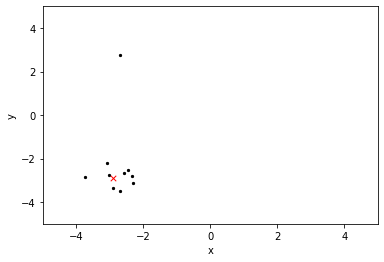

<Figure size 432x288 with 0 Axes>

In [9]:
plot_points(ELITES, OPTIMAL_POINT)

From our population of 200 individuals, ten elites were chosen as the ten best fit individuals. These will be added to the mating pool, but we'll also add them to the new population verbatim.

When selecting elites, you should remove them from the population, so the tournament selection doesn't "double dip" and we get solution reduplication. We also add the elites to the mating pool:

In [10]:
del POPULATION[:len(ELITES)]

MATING_POOL = []
MATING_POOL.extend(ELITES)

### Tournament Selection

Imagine a scenario where there were no individuals with a relatively close fitness to optima: for example, if the most fit individuals were very far from optima. When the new population is initialized based on the mating pool, the algorithm may get stuck in that area and not converge to a better solution. Likewise, if you were to have a mating pool only consisting of the same individual (reduplication), the algorithm no longer improves. 

Tournaments allow a random selection of remaining individuals in the population to compete to enter the mating pool. Even if this selection is not the most fit, sometimes you need fewer fit individuals to help the overall population by introducing diversity. Like elite selection, a proportion of the population is chosen to enter a tournament, and the most fit individual from this tournament enters the mating pool. The tournament is, however, initialized from random individuals from the population. And like elite selection, the percent of individuals who enter the tournament should be empirically found but we'll use 2%:

In [11]:
def tournament_selection(population, percent):
    """Tournament selection function.
    Creates a tournament of random individuals and returns the best.
    
    Parameters:
        population : the population to take tournament from.
        percent : the proportion of the population who enters the tournament.
    
    Returns:
        Best fit individual from tournament.
    """
    tournament = []
    # grab percent% random individuals
    for i in range(ceil(len(population)*percent)):
        random_idx = random.randint(0, len(population)-1)
        tournament.append(population.pop(random_idx)) # append to tournament
    tournament = sorted(tournament, key=styb_tang) # sort by fitness
    return tournament[0] # return best fit from tournament

TOURNAMENT = tournament_selection(POPULATION, 0.02)

MATING_POOL.append(TOURNAMENT)

Now we can add this to our plot of the mating pool:

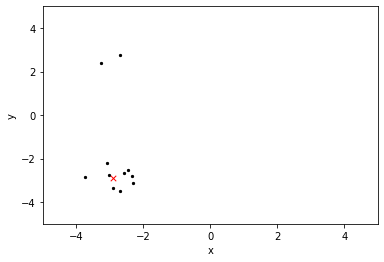

<Figure size 432x288 with 0 Axes>

In [12]:
plot_points(MATING_POOL, OPTIMAL_POINT)

Now we have our mating pool and can begin generating offspring for new generations.

## Evolving the Population

The purpose of using genetic algorithms is to mimic biological evolution. We want to evolve the population to a more fit population. To achieve this, we need to generate a new population after the initial population which takes after the mating pool. We'll take a cue from biology and implement two genetic operators: <i>crossover</i> and <i>mutation</i>.

### Crossover

Similar to two parents producing offspring which is a combination of both parents, crossover is a genetic operator which does much the same. Given two individuals from the mating pool, we'll create offspring based on the genes of each. It is not as interesting with two-dimensional data, so here is an illustration for a larger dimensional example:

<img src="./images/crossover.png"/>

In this we have two parent chromosomes (top and bottom) consisting of six genes each, with a child chromosome (middle). The child consists of four genes from the first parent and two genes from the second. This is the crux of crossover. Crossover does produce two children per run but only one is shown here for illustration. The second child instead takes the opposite genes to the first child.

There are a few crossover operators such as one-point, two-point, and uniform. For our purposes, I'll use one-point, but it will be implemented to be general to higher dimensional data. One-point crossover uses a single pivot point in the chromosome where genes prior to the pivot come from the first parent and genes after the pivot come from the next.

Crossover is not a 100% possibility, or generally doesn't need to be. A crossover rate determines how frequent the crossover operator is used, and if it is not to be used, the parents are returned as children verbatim.

In [13]:
CROSS_RATE = 1.00 # chosen for illustrative purposes

def crossover(parent_a, parent_b):
    """One-point crossover operator.
    
    Parameters:
        parent_a : the first parent.
        parent_b : the second parent.
    
    Returns:
        Two child chromosomes as a product of both parents.
    """
    # only perform crossover based on the crossover rate
    if random.uniform(0.00, 1.00) >= CROSS_RATE:
        return parent_a, parent_b
    child_a, child_b = [], []
    # find a pivot point at random
    pivot = random.randint(1, len(parent_a)-1)
    for i in range(0, len(parent_a)):
        # before pivot, use genes from one parent
        if i < pivot:
            child_a.append(parent_a[i])
            child_b.append(parent_b[i])
        # after pivot, use genes from second parent
        else:
            child_a.append(parent_b[i])
            child_b.append(parent_a[i])
    return child_a, child_b

To illustrate, we'll use points of five dimensions:

In [14]:
PARENT_A = [random.uniform(SEARCH_MIN, SEARCH_MAX) for _ in range(5)]
PARENT_B = [random.uniform(SEARCH_MIN, SEARCH_MAX) for _ in range(5)]

print("Parents:")
print(PARENT_A)
print(PARENT_B)

CHILD_A, CHILD_B = crossover(PARENT_A, PARENT_B)

print("\nChildren:")
print(CHILD_A)
print(CHILD_B)

Parents:
[-3.79099080057129, 0.6618158230479789, -4.7170009726824915, -2.1022754682625377, 3.636175856148137]
[2.335672419661069, -0.15818744094496395, -1.900648907457736, 3.26030491592946, -4.262865517505695]

Children:
[-3.79099080057129, 0.6618158230479789, -1.900648907457736, 3.26030491592946, -4.262865517505695]
[2.335672419661069, -0.15818744094496395, -4.7170009726824915, -2.1022754682625377, 3.636175856148137]


The pivot was randomly chosen as the position after the second gene: each child has genes equal to one parent for genes `0..2` and the other parent for genes `3..5`. These results would not be as exciting with our ongoing two-dimensional problem as the pivot will always be chosen between the first and second genes. At least here you can conceptualize the idea of a pivot.

This entire process generates children which are partially one parent and partially another. When we initialize our new population based on this operator, the new population will be like the mating pool as this is where each parent comes from.

### Mutation

There is another genetic operator to consider: mutation. Mutation reintroduces diversity into the system by randomizing genes based on the search space. In other words, genes will become randomized in mutation yet still be solutions within the search space. Another visualization is below:

<img src="./images/mutation.png"/>

In this, a chromosome had its 3rd and 6th gene mutated as denoted by a green arrow. The other genes were untouched during mutation.

Like crossover, mutation does not happen all the time and is based on a mutation rate. The difference, however, is this chance is on a per-gene basis. The mutation is not completely random over the entire search space: instead, we want the mutation to be not too diverse, so we cap a 50% radius range around the point such that mutation doesn't bring the point too far from where it was initially. 

Implementation of mutation is simple:

In [15]:
MUTAT_RATE = 0.50 # chosen for illustrative purposes

def mutation(child, s_min, s_max):
    """Mutation operator.
    
    Parameters:
        child : the chromosome to mutate.
        s_min : the lower bound for mutation.
        s_max : the upper bound for mutation.
    
    Returns:
        A mutated child.
    """
    for i in range(len(child)):
        # only perform mutation based on the mutation rate
        if random.uniform(0.00, 1.00) <= MUTAT_RATE:
            # find a random distance within 50% radius
            diff = random.uniform(s_min*0.5, s_max*0.5)
            # update the child axes with that distance
            child[i] += diff
            # the position is now randomized but still relatively close
            # if it's outside the search space, clamp it to within
            child[i] = max(child[i], s_min)
            child[i] = min(child[i], s_max)
    return child

To illustrate, we'll continue using the ongoing example of five-dimensional points:

In [16]:
print("Before mutation:")
print(CHILD_A)

CHILD_A = mutation(CHILD_A, SEARCH_MIN, SEARCH_MAX)

print("\nAfter mutation:")
print(CHILD_A)

Before mutation:
[-3.79099080057129, 0.6618158230479789, -1.900648907457736, 3.26030491592946, -4.262865517505695]

After mutation:
[-1.949495393391377, 0.6618158230479789, -2.677826308807843, 3.138499818346105, -2.216511152631578]


You'll see all but the second gene was randomized while the second was untouched. Using mutation, when the next generation's population is to be initialized, this ensures there's some diversity in the mating pool. Mutation <i>can</i> help less fit children become more fit but in general it is used for diversity purposes.

## New Population Initialization

Now we're ready to begin the evolution process. We'll make a driver for the evolution step using the current example and current mating pool. To evolve the population, we need to select two random parents from the mating pool, perform the genetic operators to create children, and then create a new population.

Previously we also decided a crossover and mutation rate, but these are inappropriate choices and were just used for illustrative purposes. A better range for crossover rate is `[80, 100]` and mutation rate is `[1, 10]`. These were found with some experimentation and its problem specific.

The evolution algorithm is below:

In [17]:
CROSS_RATE = 0.95
MUTAT_RATE = 0.05

def evolve(mating_pool, elites):
    """Evolves population based on genetic operators.
    
    Parameters:
        mating_pool : where to select parents from.
        elites : previously found elites.
    
    Returns:
        A new population of offspring from mating pool.
    """
    new_population = [] # store new population as list
    new_population.extend(elites) # add elites verbatim
    while len(new_population) < POP_SIZE: # while population isn't at max size
        # get both parents indices
        p_a_idx = random.randrange(len(mating_pool))
        p_b_idx = random.randrange(len(mating_pool))
        # we don't mind parents have identical genes but we don't
        # want the parents to use the same index. Parent A can be
        # equal to Parent B, but Parent A cannot be Parent B
        if p_a_idx == p_b_idx:
            continue
        # get the parents from indices
        parent_a = mating_pool[p_a_idx]
        parent_b = mating_pool[p_b_idx]
        # find children using crossover
        child_a, child_b = crossover(parent_a, parent_b)
        # mutate each child
        child_a = mutation(child_a, SEARCH_MIN, SEARCH_MAX)
        child_b = mutation(child_b, SEARCH_MIN, SEARCH_MAX)
        # add children to population
        new_population.append(child_a)
        new_population.append(child_b)
    return new_population

We can test this and use a plot to visualize where points now lay within the population:

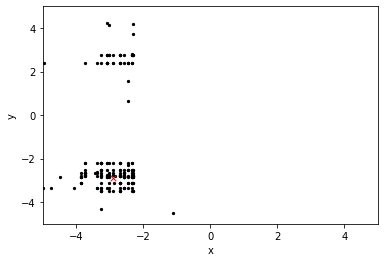

<Figure size 432x288 with 0 Axes>

In [18]:
POPULATION = evolve(MATING_POOL, ELITES)

plot_points(POPULATION, OPTIMAL_POINT)

We see a lot of candidates around the optima. But what would be real exciting is to get most of the population around that point and to verify successive calls of our evolution algorithm proves fruitful in finding the fitness minimum. First, however, we should define a way to gauge best and overall fitness of the population:

In [19]:
def get_pop_fitness(population, function):
    population = sorted(population, key=function)
    best_fitness = function(population[0])
    avg_fitness = 0
    for candidate in population:
        avg_fitness += function(candidate)
    return best_fitness, avg_fitness/len(population)

This will allow us to see not only the best and average fits of our population but also see it over time as the population evolves.

## Main Driver

We should combine everything we've done so far into one main driver which will perform selection and evolution repeatedly, output the best and average fitness per epoch, and then finally outputting what the final plot looks like.

Epoch 0, Best = -74.73671853571685, Avg = -6.140693367742695
Epoch 1, Best = -74.73671853571685, Avg = -52.82131870367969
Epoch 2, Best = -78.04540001481108, Avg = -71.03547658391498
Epoch 3, Best = -78.04540001481108, Avg = -63.918572574021745
Epoch 4, Best = -78.04540001481108, Avg = -68.72078197737048
Epoch 5, Best = -78.19304930913059, Avg = -75.37108087828716
Epoch 6, Best = -78.31067920529772, Avg = -74.14504417186374
Epoch 7, Best = -78.31067920529772, Avg = -66.04377582759469
Epoch 8, Best = -78.31067920529772, Avg = -65.01063142634493
Epoch 9, Best = -78.31067920529772, Avg = -74.46733637764939
Epoch 10, Best = -78.31067920529772, Avg = -52.27307338123222


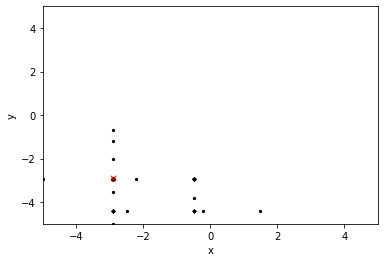

The minimum for the fitness function was found to be -78.31.


<Figure size 432x288 with 0 Axes>

In [20]:
ELITE_PROPORTION = 0.01
TOURN_PROPORTION = 0.02
EPOCHS = 10

def genetic_algorithm(el_p, to_p, dim, epochs, function):
    """Genetic algorithm driver.
    Initializes the population and evolves it over time.
    
    Parameters:
        el_p : the proportion of elites for elite selection.
        to_p : the proportion of tournament entrants for tournament selection.
        dim : dimensionality of the problem.
        epochs : how many iterations of the evolution algorithm to perform.
        function : the fitness function to evolve from.
    """
    # initially the population is random
    population = initialize_population(POP_SIZE, dim, SEARCH_MIN, SEARCH_MAX)
    # output initial best and avg fitnesses
    initial_best, initial_avg = get_pop_fitness(population, function)
    print_stats(0, initial_best, initial_avg)
    for e in range(1, epochs+1): # for each iteration
        population = sorted(population, key=function) # sort by fitness
        mating_pool = [] # init empty mating pool
        # select elites based on best fitness in population
        elites = elite_selection(population, el_p)
        # select tournament winner from random candidates
        t_winner = tournament_selection(population, to_p)
        # add the elites to the mating pool
        mating_pool.extend(elites)
        # add the tournament winner to the mating pool
        mating_pool.append(t_winner)
        # evole the population based on parents and genetic operators
        population = evolve(mating_pool, elites)
        mating_pool.clear() # erase the mating pool for next generation
        # output best and avg fitnesses for this generation
        best_fit, avg_fit = get_pop_fitness(population, function)
        print_stats(e, best_fit, avg_fit)
    # plot the final points
    plot_points(population, OPTIMAL_POINT)
    # sort population by fitness again
    population = sorted(population, key=function)
    # return the best fitness after the entire genetic algorithm
    return function(population[0])
        
def print_stats(epoch, best, avg):
    print(f'Epoch {epoch}, Best = {best}, Avg = {avg}')

best = genetic_algorithm(ELITE_PROPORTION, TOURN_PROPORTION, DIMENSIONS, EPOCHS, styb_tang)
print(f'The minimum for the fitness function was found to be {best:.2f}.')

We can see after only a few epochs, the best fitness comes very close to optimal and the average fitness increases dramatically after the first epoch and then fluctuates but still relatively close to the population best.

Just to verify for higher dimensionality because two is trivial, I've scaled it up and output the best in population fitness, average in population fitness, and consider the distance from target (i.e. how close it was to reaching the global optimum).

In [21]:
for i in range(5, 55+1, 10):
    expected = styb_tang([-2.903534 for _ in range(i)])
    found = genetic_algorithm(ELITE_PROPORTION, TOURN_PROPORTION, i, 1000, styb_tang)
    perc_there = f'{(found/expected):.2%}'
    print(f'{i} dimensions:')
    print(f'Found: {found:.2f}, Expected: {expected:.2f}, How Close: {perc_there}\n')

5 dimensions:
Found: -195.83, Expected: -195.83, How Close: 100.00%

15 dimensions:
Found: -587.48, Expected: -587.49, How Close: 100.00%

25 dimensions:
Found: -908.28, Expected: -979.15, How Close: 92.76%

35 dimensions:
Found: -1167.69, Expected: -1370.82, How Close: 85.18%

45 dimensions:
Found: -1488.01, Expected: -1762.48, How Close: 84.43%

55 dimensions:
Found: -1852.75, Expected: -2154.14, How Close: 86.01%



As above, if incorrect, it is still within the realm of correct. This is because as the problem size increases, more epochs are needed, or the genetic algorithm parameters may need to change. Parameters that work for a small problem may not scale up to a larger problem.

Since a graph of closeness to target over time for two dimensions may not show much considering how quickly it converges, I've made a graph in 55 dimensions using a population size of 500 and over 100 epochs. Otherwise the parameters remain the same.

<img width="432px" src="./images/plot_over_time.png"/>

This shows the population best (green) and population average (blue) over time. Note the population best increases or remains the same with each generation whereas the population average does fluctuate (although the trend remains improving). This is due to mutation making the population on average more diverse and thus fitness fluctuates.

Lastly, here's a full runthrough of the algorithm with original conditions in two dimensions for ten epochs:

<img width="432px" src="./images/animation.gif"/>

You can see the population does shrink around the global optimum which is the expected result.

Other than that, this wraps up my genetic algorithm tutorial.

## Final Thoughts

Genetic algorithms are optimization algorithms which can help you find global optima in each fitness function provided you also know its search space. While this tutorial used a very trivial application of minimizing a mathematical function, more abstract fitness functions can be used in place, like optimizing neural network weights in lieu of backpropagation, finding optimal particle swarm parameters, among others.

While trivial, I hope this informs people on how genetic algorithms work in one way and how the common genetic operators are used. There are still other aspects to consider, like other crossover operators (Two-Point, Uniform are common), and scheduled mutation (where the rate changes based on the acceleration of the algorithm). Ever other selection strategies for tournaments or elites can be useful to experiment with.

## Finished Code

Here is the full uncommented code:

In [ ]:
#!/usr/bin/env python3

from math import ceil
import random

def genetic_algorithm(el_p, to_p, dim, epochs, function):
    population = initialize_population(POP_SIZE, dim, SEARCH_MIN, SEARCH_MAX)
    for e in range(1, epochs+1):
        population = sorted(population, key=function)
        mating_pool = []
        elites = elite_selection(population, el_p)
        del population[:len(elites)]
        t_winner = tournament_selection(population, to_p)
        mating_pool.extend(elites)
        mating_pool.append(t_winner)
        population = evolve(mating_pool, elites)
        mating_pool.clear()
    population = sorted(population, key=function)
    best_fitness = function(population[0])
    print(f'Best minimum found was {best_fitness:.2f}.')

def evolve(mating_pool, elites):
    new_population = []
    new_population.extend(elites)
    while len(new_population) < POP_SIZE:
        p_a_idx = random.randrange(len(mating_pool))
        p_b_idx = random.randrange(len(mating_pool))
        if p_a_idx == p_b_idx:
            continue
        parent_a = mating_pool[p_a_idx]
        parent_b = mating_pool[p_b_idx]
        child_a, child_b = crossover(parent_a, parent_b)
        child_a = mutation(child_a, SEARCH_MIN, SEARCH_MAX)
        child_b = mutation(child_b, SEARCH_MIN, SEARCH_MAX)
        new_population.append(child_a)
        new_population.append(child_b)
    return new_population

def crossover(parent_a, parent_b):
    if random.uniform(0.00, 1.00) >= CROSS_RATE:
        return parent_a, parent_b
    child_a, child_b = [], []
    pivot = random.randint(1, len(parent_a)-1)
    for i in range(0, len(parent_a)):
        if i < pivot:
            child_a.append(parent_a[i])
            child_b.append(parent_b[i])
        else:
            child_a.append(parent_b[i])
            child_b.append(parent_a[i])
    return child_a, child_b

def mutation(child, s_min, s_max):
    for i in range(len(child)):
        if random.uniform(0.00, 1.00) <= MUTAT_RATE:
            diff = random.uniform(s_min*0.5, s_max*0.5)
            child[i] += diff
            child[i] = max(child[i], s_min)
            child[i] = min(child[i], s_max)
    return child

def elite_selection(population, percent):
    elites = []
    for i in range(ceil(len(population)*percent)):
        elites.append(population[i])
    return elites

def tournament_selection(population, percent):
    tournament = []
    for i in range(ceil(len(population)*percent)):
        random_idx = random.randint(0, len(population)-1)
        tournament.append(population.pop(random_idx))
    tournament = sorted(tournament, key=styb_tang)
    return tournament[0]

def styb_tang(point):
    summ = 0
    for d in point:
        summ += d**4 - (16 * d**2) + (5 * d)
    return (1 / 2) * summ

def initialize_population(size, dim, min, max):
    population = []
    for _ in range(size):
        point = []
        for _ in range(dim):
            point.append(random.uniform(min, max))
        population.append(point)
    return population

if __name__ == '__main__':
    SEARCH_MIN, SEARCH_MAX = -5.00, 5.00
    DIMENSIONS = 2
    POP_SIZE = 200
    ELITE_PROPORTION = 0.01
    TOURN_PROPORTION = 0.02
    EPOCHS = 10
    CROSS_RATE, MUTAT_RATE = 0.95, 0.05
    genetic_algorithm(ELITE_PROPORTION, TOURN_PROPORTION, DIMENSIONS, \
        EPOCHS, styb_tang)

You may wish to catch for errors (as I have done none here), and perhaps accept some of the parameters as command line arguments. This code, as-is, should run in a terminal but allows for zero customization unless you change the code manually. Some parameters might include mutation and crossover rates, population size, how many epochs, etc.

You can save this code as `genetic_algorithm.py` and execute it as one of the below:

```
$ python3 genetic_algorithm.py
$ ./genetic_algorithm.py
```

You can also find the code in `./code`. For a Java implementation I did for string decryption, you can see <a href="https://github.com/stratzilla/genetic-decryption">here</a>.